- Train: 80%
- Validation: 10% 
- Test: 10% 

In [1]:
import os
import json
import shutil
import random
from datetime import datetime
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)

In [2]:
DATA_PATH = Path("/Users/amirah/Ghiras's datast/THE DATA")
WORK_DIR = Path("./plant_disease_project2")
SPLIT_DIR = WORK_DIR / "data_split"

SPLIT_DIR.mkdir(parents=True, exist_ok=True)

IMG_EXTS = [".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp"]
TRAIN_RATIO = 0.80
VAL_RATIO = 0.10
TEST_RATIO = 0.10
RANDOM_SEED = 42

helper

In [3]:
def is_image(p: Path) -> bool:
    return p.suffix.lower() in IMG_EXTS

Collecting classes

In [4]:
classes = sorted([d for d in DATA_PATH.iterdir() if d.is_dir()], key=lambda p: p.name)
print(f" Number of classes: {len(classes)}\n")

 Number of classes: 96



Defining stratified split function

In [5]:
def stratified_split_paths(paths, train_ratio, val_ratio, test_ratio, seed=RANDOM_SEED):
    n = len(paths)
    idx = list(range(n))
    random.Random(seed).shuffle(idx)  # تثبيت العشوائية
    
    # حساب عدد الصور لكل قسم
    n_train = int(round(n * train_ratio))
    n_val = int(round(n * val_ratio))
    n_test = n - n_train - n_val  # الباقي لتجنب تأثير التقريب
    
    # فصل الفهارس
    train_idx = idx[:n_train]
    val_idx = idx[n_train:n_train + n_val]
    test_idx = idx[n_train + n_val:]
    
    # استخراج الصور
    train = [paths[i] for i in train_idx]
    val = [paths[i] for i in val_idx]
    test = [paths[i] for i in test_idx]
    
    return train, val, test

print(" Split function ready\n")

 Split function ready



reating folder structure

In [6]:
for split in ["train", "val", "test"]:
    for c in classes:
        (SPLIT_DIR / split / c.name).mkdir(parents=True, exist_ok=True)

print(f"✓ Folder structure created:")
print(f"  {SPLIT_DIR}/")
print(f"  ├── train/")
print(f"  ├── val/")
print(f"  └── test/\n")

✓ Folder structure created:
  plant_disease_project2/data_split/
  ├── train/
  ├── val/
  └── test/



Splitting and copying images

In [7]:
split_rows = []
total_copied = 0

for c in tqdm(classes, desc="Processing classes"):
    cls_name = c.name
    paths = [p for p in c.iterdir() if is_image(p)]
    
    if len(paths) == 0:
        continue
    
    # تقسيم داخل الكلاس
    train_paths, val_paths, test_paths = stratified_split_paths(
        paths, TRAIN_RATIO, VAL_RATIO, TEST_RATIO, seed=RANDOM_SEED
    )
    
    # نسخ الملفات
    for split_name, plist in [("train", train_paths), ("val", val_paths), ("test", test_paths)]:
        for src in plist:
            dst = SPLIT_DIR / split_name / cls_name / src.name
            try:
                shutil.copy2(src, dst)
                split_rows.append({
                    "split": split_name,
                    "class": cls_name,
                    "path": str(dst)
                })
                total_copied += 1
            except Exception as e:
                print(f" Failed to copy {src}: {e}")

print(f"\n Successfully copied {total_copied:,} images\n")

Processing classes: 100%|██████████| 96/96 [00:26<00:00,  3.64it/s]


 Successfully copied 83,668 images



COUNTS (PER SPLIT & CLASS)

In [8]:
# Building DataFrames

df_split = pd.DataFrame(split_rows)
print(f" DataFrame ready with {len(df_split)} rows\n")

#Computing statistics

def count_by_split(df_split: pd.DataFrame) -> pd.DataFrame: #حساب عدد الصور لكل (split, class)
    return (df_split.groupby(["split", "class"])["path"].count()
            .reset_index()
            .rename(columns={"path": "count"})
            .sort_values(["split", "class"])
            .reset_index(drop=True))

df_counts = count_by_split(df_split)

# ملخص سريع لكل split
summary = (df_split.groupby(["split"])["path"].count()
           .reset_index()
           .rename(columns={"path": "total_images"}))

print(" Image distribution per (split, class) - first 10:")
print(df_counts.head(10).to_string(index=False))

print("\n Overall summary:")
print(summary.to_string(index=False))

 DataFrame ready with 83668 rows

 Image distribution per (split, class) - first 10:
split                                    class  count
 test                         Apple_Apple_scab    252
 test                          Apple_Black_rot    249
 test                   Apple_Cedar_apple_rust    220
 test                            Apple_healthy    250
 test                        Blueberry_healthy    181
 test                    Cherry_Powdery_mildew    169
 test                           Cherry_healthy    182
 test Corn_Cercospora_leaf_spot Gray_leaf_spot    164
 test                        Corn_Common_rust_    190
 test                Corn_Northern_Leaf_Blight    191

 Overall summary:
split  total_images
 test          8367
train         66934
  val          8367


 حفظ الجداول

In [9]:
df_counts.to_csv(SPLIT_DIR / "class_counts_per_split.csv", index=False)
summary.to_csv(SPLIT_DIR / "split_totals.csv", index=False)

print("\n Saved:")
print("  • class_counts_per_split.csv")
print("  • split_totals.csv\n")


 Saved:
  • class_counts_per_split.csv
  • split_totals.csv



Plotting class distribution

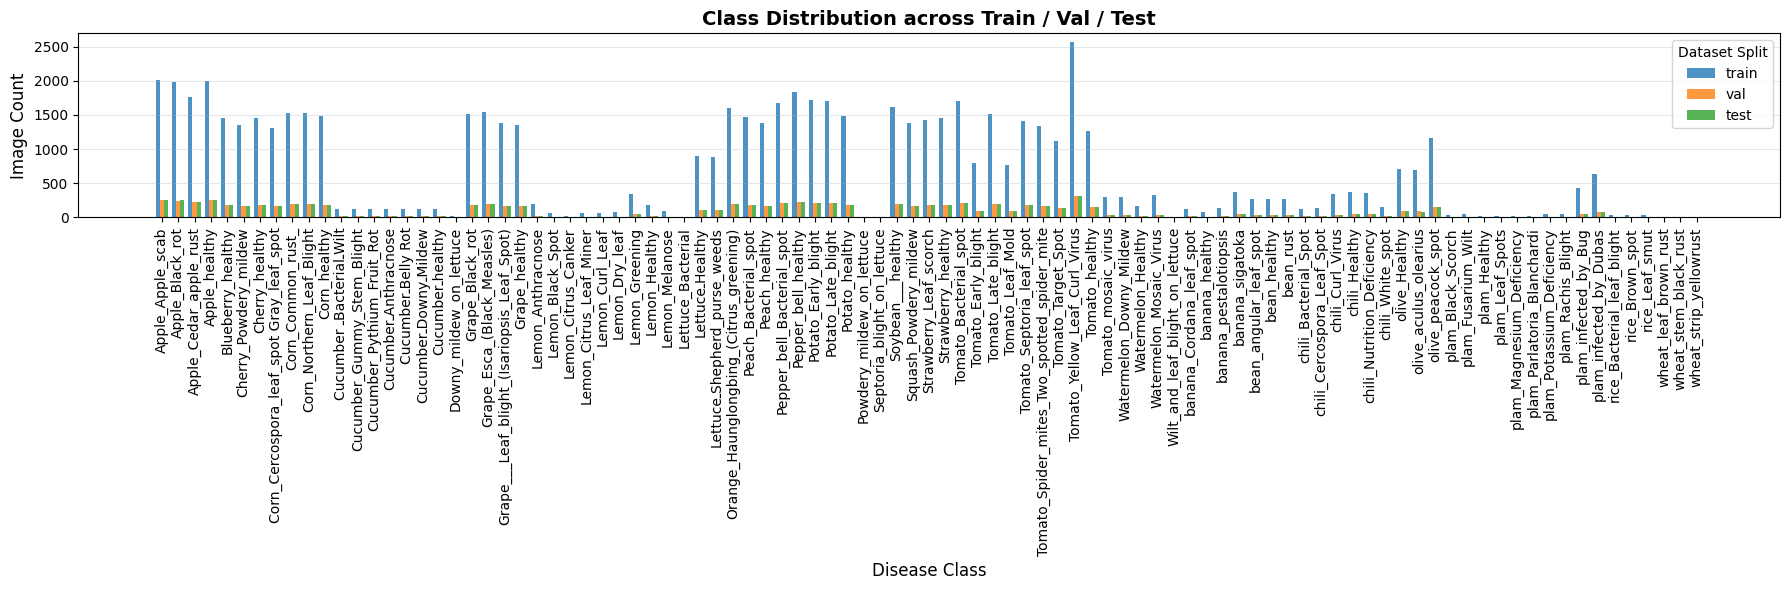

 Plot displayed



In [10]:
dfp = df_counts.pivot(index="class", columns="split", values="count").fillna(0).sort_index()
splits = ["train", "val", "test"]
classes_order = dfp.index.tolist()

# رسم
x = np.arange(len(classes_order))
width = 0.25

plt.figure(figsize=(18, 6))
for i, s in enumerate(splits):
    plt.bar(x + (i - 1) * width, dfp[s].values, width, label=s, alpha=0.8)

plt.xlabel("Disease Class", fontsize=12)
plt.ylabel("Image Count", fontsize=12)
plt.title("Class Distribution across Train / Val / Test", fontsize=14, fontweight='bold')
plt.xticks(x, classes_order, rotation=90)
plt.legend(title="Dataset Split", fontsize=10)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(" Plot displayed\n")

Checking ratios (80/10/10)

In [11]:

chk = df_counts.pivot(index="class", columns="split", values="count").fillna(0)
chk["total"] = chk.sum(axis=1)
chk["train%"] = (chk["train"] / chk["total"] * 100).round(1)
chk["val%"] = (chk["val"] / chk["total"] * 100).round(1)
chk["test%"] = (chk["test"] / chk["total"] * 100).round(1)

print(" Ratio check (first 10 classes):")
print(chk[["train%", "val%", "test%"]].head(10).to_string())

print("\n✓ Overall ratios:")
total_by_split = chk[["train", "val", "test"]].sum()
grand_total = total_by_split.sum()
print(f"  • Train: {total_by_split['train']:.0f} ({total_by_split['train']/grand_total*100:.1f}%)")
print(f"  • Val: {total_by_split['val']:.0f} ({total_by_split['val']/grand_total*100:.1f}%)")
print(f"  • Test: {total_by_split['test']:.0f} ({total_by_split['test']/grand_total*100:.1f}%)")

print("\n" + "="*80)
print(" Stratified split completed successfully!")
print("="*80)

print(f"\n Final structure:")
print(f"  {SPLIT_DIR}/")
print(f"  ├── train/ ({total_by_split['train']:.0f} images)")
print(f"  ├── val/ ({total_by_split['val']:.0f} images)")
print(f"  ├── test/ ({total_by_split['test']:.0f} images)")
print(f"  ├── class_counts_per_split.csv")
print(f"  └── split_totals.csv")

print(f"\n Data is ready for training!")
print("="*80)

 Ratio check (first 10 classes):
split                                     train%  val%  test%
class                                                        
Apple_Apple_scab                            80.0  10.0   10.0
Apple_Black_rot                             80.0  10.0   10.0
Apple_Cedar_apple_rust                      80.0  10.0   10.0
Apple_healthy                               80.0  10.0   10.0
Blueberry_healthy                           80.0  10.0   10.0
Cherry_Powdery_mildew                       80.0  10.0   10.0
Cherry_healthy                              80.0  10.0   10.0
Corn_Cercospora_leaf_spot Gray_leaf_spot    80.0  10.0   10.0
Corn_Common_rust_                           80.0  10.0   10.0
Corn_Northern_Leaf_Blight                   80.0  10.0   10.0

✓ Overall ratios:
  • Train: 66934 (80.0%)
  • Val: 8367 (10.0%)
  • Test: 8367 (10.0%)

 Stratified split completed successfully!

 Final structure:
  plant_disease_project2/data_split/
  ├── train/ (66934 images)
  ├── v